In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator
import matplotlib.ticker as mtick
import os
import json
import sys
import datetime
from datetime import date
from matplotlib.dates import MO, WeekdayLocator, MonthLocator
from datetime import datetime, UTC, date
from matplotlib.ticker import FuncFormatter

# Append utils to path for logo import
sys.path.append("utils")
from logo import add_logo


date = 'April 27th, 2025'

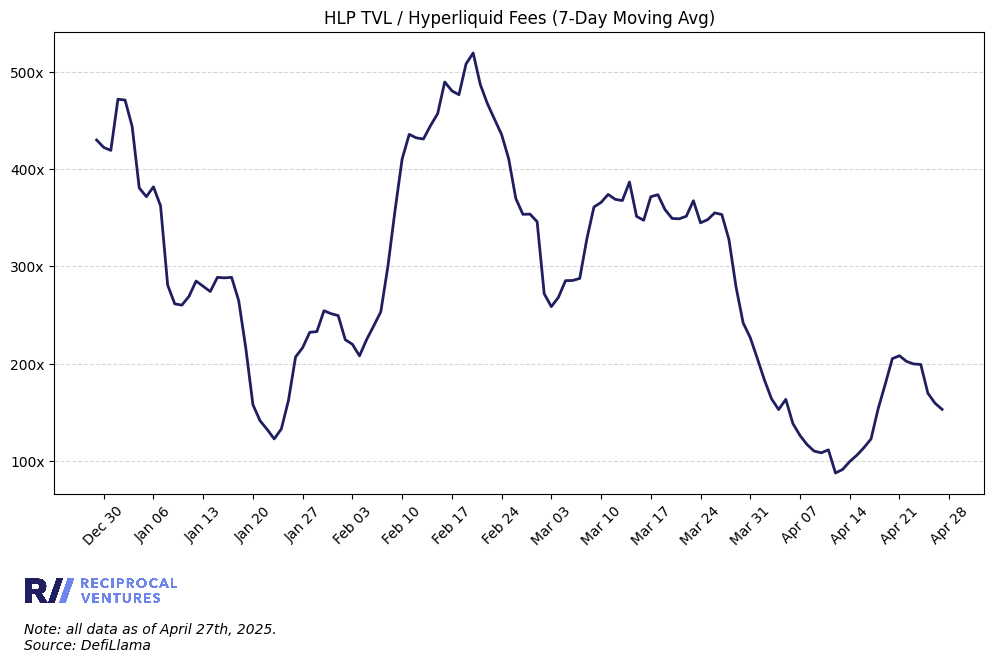

          date           tvl     fees  tvl-to-fees  tvl-to-fees-7d
115 2025-04-18  1.692546e+08   513867   329.374416      153.659050
116 2025-04-19  1.820471e+08   585204   311.083164      178.969351
117 2025-04-20  1.900151e+08   634619   299.415992      205.243816
118 2025-04-21  1.906174e+08  1487931   128.109055      208.230965
119 2025-04-22  1.892652e+08  2097862    90.218115      202.369413
120 2025-04-23  1.915457e+08  2159393    88.703488      199.777406
121 2025-04-24  1.966202e+08  1328875   147.959880      199.266301
122 2025-04-25  1.988023e+08  1620653   122.668041      169.736819
123 2025-04-26  1.982808e+08   828695   239.268766      159.477620
124 2025-04-27  1.995736e+08   783146   254.835758      153.109015


In [2]:
# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load HLP TVL data
with open("raw-data/defillama-raw-data/defillama_HLP.json", "r") as f:
    hlp_data = json.load(f)

hlp_raw = hlp_data["chainTvls"]["Hyperliquid"]["tvl"]
hlp_df = pd.DataFrame(hlp_raw)
hlp_df["date"] = pd.to_datetime(hlp_df["date"], unit="s")
hlp_df = hlp_df.rename(columns={"totalLiquidityUSD": "tvl"})
hlp_df = hlp_df[["date", "tvl"]]

# Merge datasets
df = pd.merge(hlp_df, fee_df, on="date", how="inner")
df["tvl-to-fees"] = df["tvl"] / df["fees"]

# Calculate trailing 7-day average
df["tvl-to-fees-7d"] = df["tvl-to-fees"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["tvl-to-fees-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Y-axis formatting
ax.set_title("HLP TVL / Hyperliquid Fees (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:,.0f}x'))

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/tvl-to-fees_ratio_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "tvl", "fees", "tvl-to-fees", "tvl-to-fees-7d"]].tail(10))

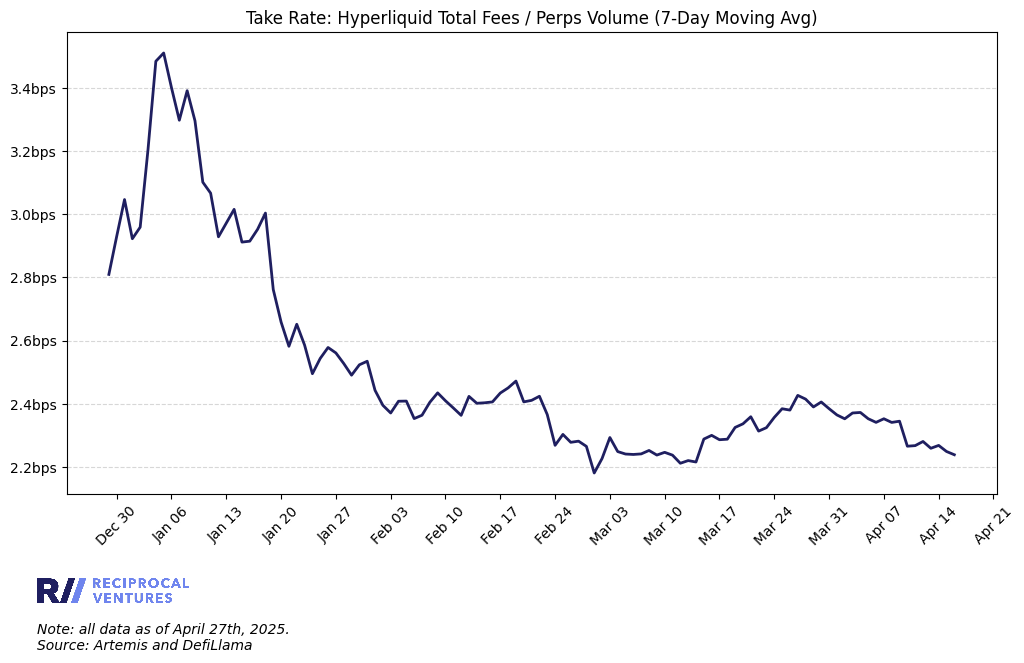

          date     fees  perps-volume  take-rate  take-rate-7d
105 2025-04-08  1746313  7.827351e+09   2.231040      2.340572
106 2025-04-09  2837027  1.270113e+10   2.233680      2.344451
107 2025-04-10  1686123  7.394696e+09   2.280179      2.265196
108 2025-04-11  1327396  5.731433e+09   2.315993      2.267029
109 2025-04-12  1164323  5.070751e+09   2.296155      2.280189
110 2025-04-13  1365048  6.333385e+09   2.155321      2.258602
111 2025-04-14  1491560  6.316587e+09   2.361339      2.267672
112 2025-04-15  1221402  5.825376e+09   2.096692      2.248480
113 2025-04-16  1508963  6.982591e+09   2.161036      2.238102
114 2025-04-17  1085608           NaN        NaN           NaN


In [3]:
# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp"], unit="s")
fee_df = fee_df[["date", "fees"]]

# Load Hyperliquid perps volume data
volume_df = pd.read_csv('raw-data/artemis-raw-data/artemis_perps-trading-volume.csv')
volume_df['Date'] = pd.to_datetime(volume_df['Date'], format='%d-%b-%y')
volume_df.rename(columns={'Date': 'date', 'Hyperliquid': 'perps-volume'}, inplace=True)

# Merge datasets
df = pd.merge(volume_df, fee_df, on="date", how="inner")
df["take-rate"] = df["fees"] / df["perps-volume"] * 10000  # Convert to BPS

# Calculate trailing 7-day average
df["take-rate-7d"] = df["take-rate"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["take-rate-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Take Rate: Hyperliquid Total Fees / Perps Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}bps'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/take-rate_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "fees", "perps-volume", "take-rate", "take-rate-7d"]].tail(10))


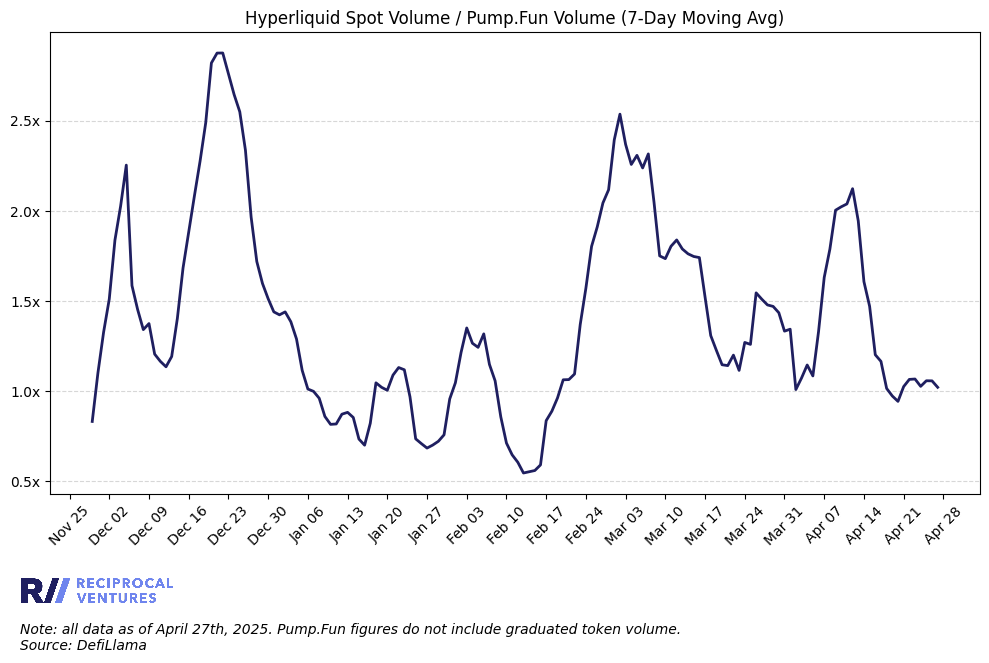

          date  hyperliquid-spot-volume  hyperliquid-spot-volume  \
146 2025-04-18                 94799665                 94799665   
147 2025-04-19                 93687537                 93687537   
148 2025-04-20                 92510970                 92510970   
149 2025-04-21                153905343                153905343   
150 2025-04-22                167698100                167698100   
151 2025-04-23                169388947                169388947   
152 2025-04-24                117675576                117675576   
153 2025-04-25                114067436                114067436   
154 2025-04-26                 89325385                 89325385   
155 2025-04-27                 65942651                 65942651   

     hyperliquid-memecoin-market-share  hyperliquid-memecoin-market-share-7d  
146                           0.685005                              1.015363  
147                           0.829403                              0.973503  
148           

In [4]:
# Load Hyperliquid spot volume data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json", "r") as f:
    hyperliquid_spot_volume_data = json.load(f)

hyperliquid_spot_volume_df = pd.DataFrame(hyperliquid_spot_volume_data["totalDataChart"], columns=["timestamp", "hyperliquid-spot-volume"])
hyperliquid_spot_volume_df["date"] = pd.to_datetime(hyperliquid_spot_volume_df["timestamp"], unit="s")
hyperliquid_spot_volume_df = hyperliquid_spot_volume_df[["date", "hyperliquid-spot-volume"]]

# Load Pump.Fun volume data
with open("raw-data/defillama-raw-data/defillama_pumpfun-spot-volumes.json", "r") as f:
    pumpfun_spot_volume_data = json.load(f)

pumpfun_spot_volume_df = pd.DataFrame(pumpfun_spot_volume_data["totalDataChart"], columns=["timestamp", "pumpfun-spot-volume"])
pumpfun_spot_volume_df["date"] = pd.to_datetime(pumpfun_spot_volume_df["timestamp"], unit="s")
pumpfun_spot_volume_df = pumpfun_spot_volume_df[["date", "pumpfun-spot-volume"]]

# Merge datasets
df = pd.merge(hyperliquid_spot_volume_df, pumpfun_spot_volume_df, on="date", how="inner")
df["hyperliquid-memecoin-market-share"] = df["hyperliquid-spot-volume"] / df["pumpfun-spot-volume"]

# Calculate trailing 7-day average
df["hyperliquid-memecoin-market-share-7d"] = df["hyperliquid-memecoin-market-share"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["hyperliquid-memecoin-market-share-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid Spot Volume / Pump.Fun Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.1f}x'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. Pump.Fun figures do not include graduated token volume.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid-to-pumpfun-volume-ratio_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "hyperliquid-spot-volume", "hyperliquid-spot-volume", "hyperliquid-memecoin-market-share", "hyperliquid-memecoin-market-share-7d"]].tail(10))

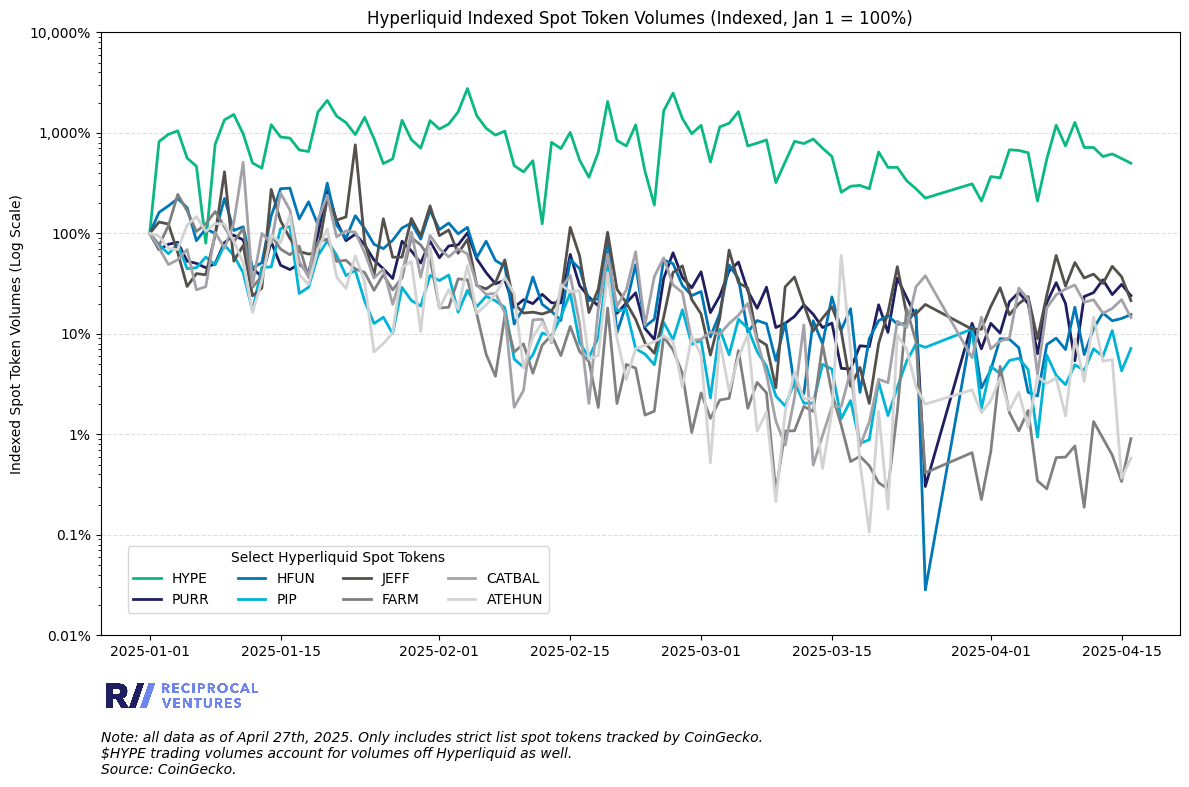

          date         HYPE       PURR       HFUN        PIP       JEFF  \
92  2025-04-07   550.734734  20.451432   7.828174   6.132986  24.394752   
93  2025-04-08  1189.713142  32.285376   9.056562   3.859054  60.261440   
94  2025-04-09   741.433332  20.026953   6.976906   3.117972  29.833857   
95  2025-04-10  1269.900497   5.393681  18.383283   4.922878  51.244331   
96  2025-04-11   715.545516  23.491927   6.211235   4.325685  35.890344   
97  2025-04-12   714.577708  25.695734  11.340230   7.091407  39.269146   
98  2025-04-13   580.886354  34.483476  16.106702   5.966686  31.674685   
99  2025-04-14   616.484813  24.565764  13.480219  10.782913  46.961992   
100 2025-04-15   554.963741  31.019274  14.204097   4.282122  36.997383   
101 2025-04-16   498.405878  23.984125  15.546348   7.136441  21.417044   

         FARM     CATBAL     ATEHUN  
92   0.286605  18.198040   3.209780  
93   0.586293  24.469390   3.637409  
94   0.593421  27.907685   1.523739  
95   0.766109  30.5631

In [5]:
# Load Hyperliquid spot stric list volume data

# Load color palette
color_palette = {
    'Hyperliquid':'#09b882', 'Black':'#000000',
    'Bold Blue':'#1f1f60', 'Sky Blue':'#6f85ee',
    'blue 1':'#03045e', 'blue 2':'#0077b6',
    'blue 3':'#00b4d8', 'blue 4':'#90e0ef',
    'blue 5':'#caf0f8', 'blue 6':'#d9f4fa', 'blue 7': '#f1fcfe',
    'Mid Grey':'#54504c','Other Grey':'#a4a2a8', 'Pure Grey': '#808080','Lighter Grey': '#A9A9A9','Lightest Grey': '#D3D3D3',
}

asset_colors = {
    'HYPE': color_palette['Hyperliquid'],
    'PURR': color_palette['Bold Blue'],
    'HFUN': color_palette['blue 2'],
    'PIP': color_palette['blue 3'],
    'JEFF': color_palette['Mid Grey'],
    'FARM': color_palette['Pure Grey'],
    'CATBAL': color_palette['Other Grey'],
    'ATEHUN': color_palette['Lightest Grey'],
}

# Create asset map
assets = {
    'hyperliquid': 'HYPE',
    "purr-2": "PURR",
    "hypurr-fun": "HFUN",
    "pip-3": "PIP",
    "jeff-3": "JEFF",
    "farm-2": "FARM",
    "catbal": "CATBAL",
    'atehun': 'ATEHUN',
}

df_master = None

for raw_id, asset in assets.items():
    # Load data spot asset data
    path = f"raw-data/coingecko-raw-data/coingecko_{raw_id}_spot_strict_list_data.json"
    with open(path) as f:
        data = json.load(f)

    coin_df = (
        pd.DataFrame(data["total_volumes"], columns=["timestamp", f"{asset}-spot-volume"])
          .assign(date=lambda d: pd.to_datetime(d["timestamp"], unit="ms"))
          .loc[:, ["date", f"{asset}-spot-volume"]]
    )

    # Transform data to 7d avg index
    first_volume = coin_df[f"{asset}-spot-volume"].iloc[0]
    coin_df[f"{asset}-indexed-spot-volume"] = coin_df[f"{asset}-spot-volume"] / first_volume * 100
    coin_df[f"{asset}-indexed-spot-volume-7d"] = coin_df[f"{asset}-indexed-spot-volume"].rolling(7).mean()
    coin_df[f'{asset}-spot-volume-7d'] = coin_df[f'{asset}-spot-volume'].rolling(7).mean()

    # Kill values not getting plotted
    coin_df[f'{asset}'] = coin_df[f"{asset}-indexed-spot-volume"]
    coin_df = coin_df[["date", f"{asset}"]]
    
    # Merge dataframes
    df_master = coin_df if df_master is None else df_master.merge(coin_df, on="date", how="inner")
    df_master = df_master.sort_values("date").reset_index(drop=True)

# Create the line chart
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting the line chart with custom colors
for raw_id, asset in assets.items():
    ax.plot(
        df_master['date'], 
        df_master[asset], 
        label=asset, 
        color=asset_colors[asset],
        linewidth=2
    )

# Setting labels and title
ax.set_title('Hyperliquid Indexed Spot Token Volumes (Indexed, Jan 1 = 100%)')
ax.set_ylabel('Indexed Spot Token Volumes (Log Scale)')

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Apply a percentage formatter to the y-axis
def format_y(x, _):
    """Integers for values ≥ 1, variable decimals for values < 1."""
    if x >= 1:
        return f"{x:,.0f}%" # e.g. 2 000
    # format to 10 dp then strip trailing zeros/decimal point
    return f"{x:.10f}".rstrip("0").rstrip(".")+"%"

ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_y))

# Set y-axis limits with lower bound as 10 (10^1)
ax.set_ylim(0.01, 10000)

# Add grid lines for better readability
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Add logo
add_logo(ax, position=(0.075, -0.1))

# Add sources and note
text_box = ax.text(0, -0.23, f"Note: all data as of {date}. Only includes strict list spot tokens tracked by CoinGecko.\n$HYPE trading volumes account for volumes off Hyperliquid as well.\nSource: CoinGecko.",
                   ha='left', transform=ax.transAxes, fontsize=10,
                   bbox=dict(facecolor='white', alpha=0), fontstyle='italic')

# Center the legend below the chart
plt.legend(title='Select Hyperliquid Spot Tokens', bbox_to_anchor=(0.22, 0.16), loc='upper center', ncol=4)

# Ensure the layout adapts to fit all elements (legend, text, etc.)
plt.tight_layout()

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid-indexed-spot-token-volumes.png", dpi=300, bbox_inches='tight')

# Show
plt.show()
print(df_master.tail(10))

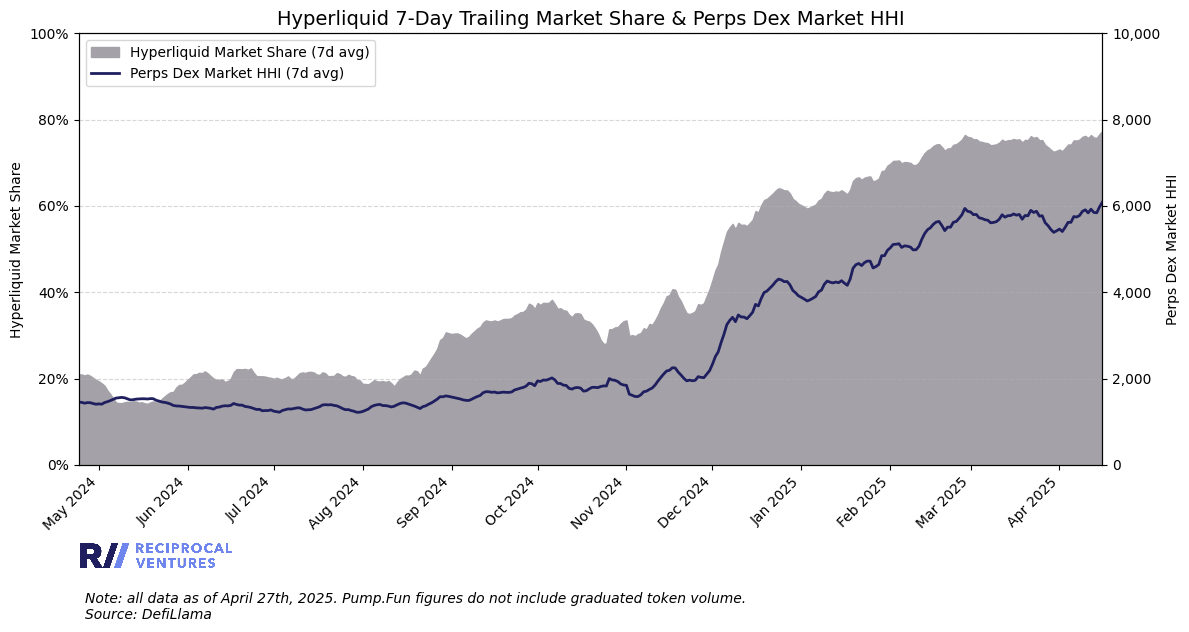

          date  market_share      ms_7d          hhi       hhi_7d
355 2025-04-08     77.228630  75.389841  6038.494594  5779.223736
356 2025-04-09     78.306628  76.026315  6202.778184  5874.672297
357 2025-04-10     77.153257  76.258232  6041.563253  5912.006073
358 2025-04-11     74.727847  75.772607  5668.701714  5841.197767
359 2025-04-12     74.213667  76.443727  5599.281147  5925.286862
360 2025-04-13     71.460748  75.840823  5284.338779  5850.098938
361 2025-04-14     77.447991  75.791253  6065.108823  5842.895213
362 2025-04-15     83.490097  76.685748  7010.341427  5981.730475
363 2025-04-16     83.297362  77.398710  6978.672192  6092.572476
364 2025-04-17      0.000000  66.376816  1568.493632  5453.562530


In [6]:
# FIX LOGO AND GENERAL CLEANUP

# 1) Load & parse CSV
df = pd.read_csv(
    "raw-data/artemis-raw-data/artemis_perps-trading-volume.csv",
    dtype={"Date": str}
)
df["date"] = pd.to_datetime(df["Date"], format="%d-%b-%y")
df.drop(columns=["Date"], inplace=True)

# 2) Compute volumes & drop zero days
dex_cols = [c for c in df.columns if c != "date"]
df[dex_cols] = df[dex_cols].fillna(0)
df["total_volume"] = df[dex_cols].sum(axis=1)
df = df[df["total_volume"] > 0].copy()

# 3) Market share & HHI
df["market_share"] = df["Hyperliquid"] / df["total_volume"] * 100
shares = df[dex_cols].div(df["total_volume"], axis=0) * 100
df["hhi"] = (shares ** 2).sum(axis=1)

# 4) 7‑day trailing averages
df["ms_7d"]  = df["market_share"].rolling(7, min_periods=7).mean()
df["hhi_7d"] = df["hhi"].rolling(7, min_periods=7).mean()

# 5) Drop any rows without a full 7‑day average, plus the very last day
plot_df = df[df["ms_7d"].notna()].iloc[:-1]

# 6) Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Area: Hyperliquid market share
ax1.fill_between(
    plot_df["date"], plot_df["ms_7d"],
    color="#a4a2a8", alpha=1,
    label="Hyperliquid Market Share (7d avg)"
)
ax1.set_ylabel("Hyperliquid Market Share")
ax1.set_ylim(0, 100)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

# X‑axis exactly from first valid day → last
ax1.set_xlim(plot_df["date"].iloc[0], plot_df["date"].iloc[-1])
ax1.margins(x=0)                  # no extra padding
fig.subplots_adjust(left=0.07)    # tighten left edge

# Monthly ticks, lighter crowding
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Line: Perps‑DEX HHI
ax2 = ax1.twinx()
ax2.plot(
    plot_df["date"], plot_df["hhi_7d"],
    color="#1f1f60", linewidth=2,
    label="Perps Dex Market HHI (7d avg)"
)
ax2.set_ylabel("Perps Dex Market HHI")
ax2.set_ylim(0, 10_000)
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

# Title, grid & legend
ax1.set_title("Hyperliquid 7‑Day Trailing Market Share & Perps Dex Market HHI", fontsize=14)
ax1.grid(axis="y", linestyle="--", alpha=0.5)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")

# Save & show
add_logo(ax1, position=(0.075, -0.21))
plt.figtext(0.075, -0.04, f"Note: all data as of {date}. Pump.Fun figures do not include graduated token volume.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')
plt.tight_layout()
plt.savefig("plots/hyperliquid_marketshare_hhi_7d.png", dpi=300, bbox_inches="tight")
plt.show()

# Debug print
print(df[["date","market_share","ms_7d","hhi","hhi_7d"]].tail(10))


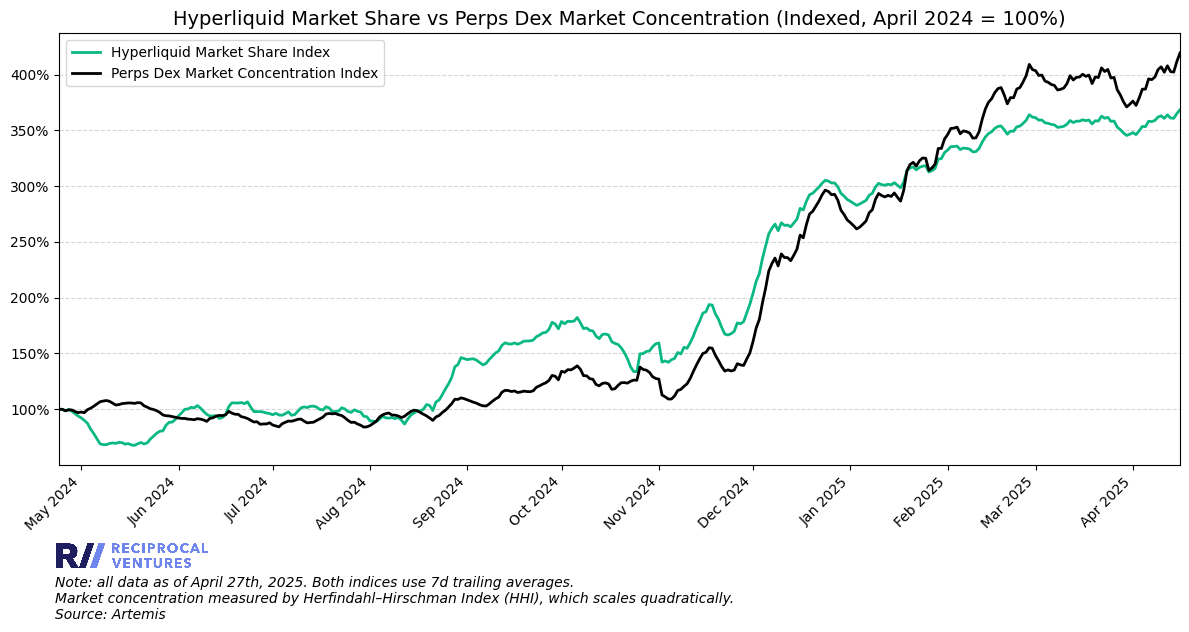

             Aevo         ApeX      Avantis       Bluefin  Drift Protocol  \
354  1.893289e+07  482539864.0  52322850.74  1.116223e+08    2.757601e+08   
355  7.951830e+06  269397687.2  17516227.95  9.135697e+07    1.453212e+08   
356  1.207307e+07  371060293.4  15032929.84  9.772171e+07    2.043770e+08   
357  1.305575e+07  251647161.8  11736928.75  7.751257e+07    9.936844e+07   
358  8.583353e+06  278866855.5   9789503.48  8.117606e+07    1.191645e+08   
359  6.129943e+06  309788923.4  14371987.19  7.382531e+07    1.240203e+08   
360  5.891644e+06  328372885.0  10987507.41  7.671639e+07    1.034122e+08   
361  6.478715e+06  281138678.9  17882976.11  5.093400e+07    1.479805e+08   
362  6.463340e+06  231367729.8  29804181.56  4.318482e+07    1.173241e+08   
363  7.408841e+06  235526389.2  37915755.54  5.206847e+07    1.364144e+08   

         dYdX v3      dYdX v4  Gains Network           GMX  Holdstation  ...  \
354  516435708.4  516435708.4            0.0  5.831641e+08  25258746.27 

In [7]:
import sys
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator
import matplotlib.ticker as mtick

# 0) logo util
sys.path.append("utils")
from logo import add_logo

# 1) Load & parse CSV
df = pd.read_csv(
    "raw-data/artemis-raw-data/artemis_perps-trading-volume.csv",
    dtype={"Date": str}
)
df["date"] = pd.to_datetime(df["Date"], format="%d-%b-%y")
df.drop(columns=["Date"], inplace=True)

# 2) Compute volumes & drop zero‑volume days
dex_cols = [c for c in df.columns if c != "date"]
df[dex_cols] = df[dex_cols].fillna(0)
df["total_volume"] = df[dex_cols].sum(axis=1)
df = df[df["total_volume"] > 0].copy()

# 3) Market share & HHI
df["market_share"] = df["Hyperliquid"] / df["total_volume"] * 100
shares = df[dex_cols].div(df["total_volume"], axis=0) * 100
df["hhi"] = (shares ** 2).sum(axis=1)

# 4) 7‑day trailing averages
df["ms_7d"]  = df["market_share"].rolling(7, min_periods=7).mean()
df["hhi_7d"] = df["hhi"].rolling(7, min_periods=7).mean()

# 5) Prepare plot DataFrame (drop initial NaNs & last incomplete day)
plot_df = df[df["ms_7d"].notna()].iloc[:-1].copy()

# 6) Build index series (100 at first date)
idx_df = plot_df.copy()
idx_df["ms_index"]  = idx_df["ms_7d"]  / idx_df["ms_7d"].iloc[0]  * 100
idx_df["hhi_index"] = idx_df["hhi_7d"] / idx_df["hhi_7d"].iloc[0] * 100

# 7) Plot indexed growth
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    idx_df["date"], idx_df["ms_index"], color='#09b882',
    linewidth=2, label="Hyperliquid Market Share Index"
)
ax.plot(
    idx_df["date"], idx_df["hhi_index"], color='black',
    linewidth=2, label="Perps Dex Market Concentration Index"
)

# 8) Styling
ax.set_title("Hyperliquid Market Share vs Perps Dex Market Concentration (Indexed, April 2024 = 100%)", fontsize=14)
ax.set_xlim(idx_df["date"].iloc[0], idx_df["date"].iloc[-1])

# format x‑axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# format y‑axis as percentage of the base 100
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))

ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.margins(x=0)
fig.subplots_adjust(left=0.07)
ax.legend(loc="upper left")

# 9) Logo & footnote
add_logo(ax, position=(0.065, -0.21))
plt.figtext(
    0.05, -0.04,
    f"Note: all data as of {date}. Both indices use 7d trailing averages.\nMarket concentration measured by Herfindahl–Hirschman Index (HHI), which scales quadratically.\nSource: Artemis",
    ha='left', fontsize=10, style='italic'
)

# 10) Save & show
plt.tight_layout()
plt.savefig("plots/hyperliquid_HHI_indexed_growth.png", dpi=300, bbox_inches="tight")
plt.show()

print(idx_df.tail(10))

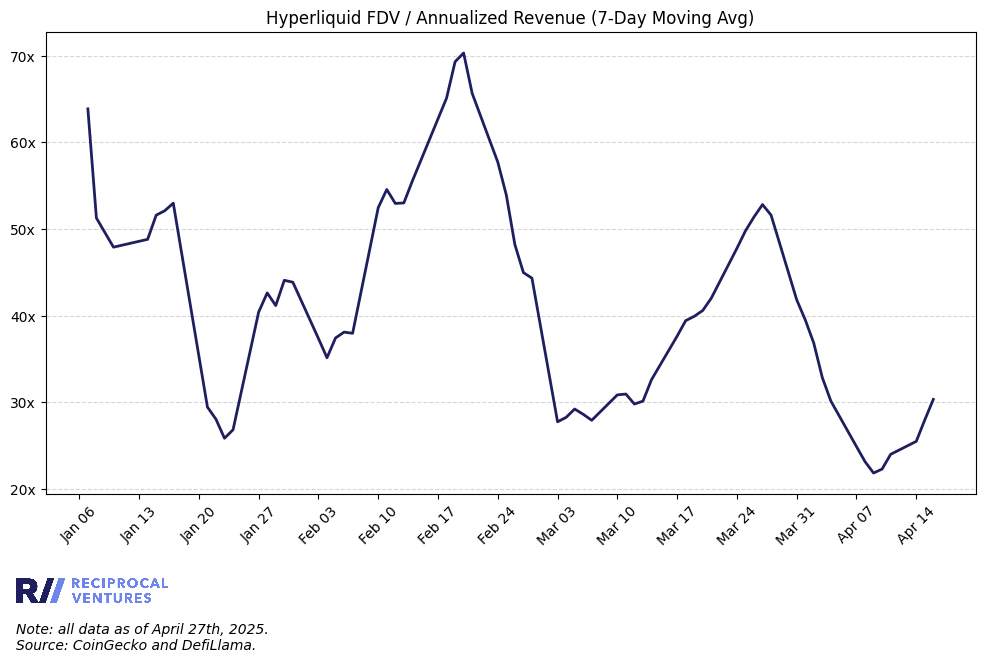

         date     fees  annualized-fees      price           fdv  \
61 2025-04-03  1715095        626009675  11.831829  1.183183e+10   
62 2025-04-04  1815068        662499820  11.716571  1.171657e+10   
63 2025-04-07  3117000       1137705000  10.266673  1.026667e+10   
64 2025-04-08  1746313        637404245  11.490222  1.149022e+10   
65 2025-04-09  2837027       1035514855  11.202466  1.120247e+10   
66 2025-04-10  1686123        615434895  13.580674  1.358067e+10   
67 2025-04-11  1327396        484499540  14.341905  1.434190e+10   
68 2025-04-14  1491560        544419400  15.362708  1.536271e+10   
69 2025-04-15  1221402        445811730  15.759650  1.575965e+10   
70 2025-04-16  1508963        550771495  15.109160  1.510916e+10   

    hype-fdv-rev-multiple  hype-fdv-rev-multiple-7d  coin_market_cap  \
61              18.900394                 32.867089     3.588607e+10   
62              17.685395                 30.163088     3.374039e+10   
63               9.024020          

In [8]:
# total supply for FDV
total_hype_tokens = 1000000000

# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp_s", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp_s"], unit="s")
fee_df = fee_df[["date", "fees"]]
fee_df['annualized-fees'] = fee_df['fees'] * 365

# Load Hyperliquid close price data
with open("raw-data/coingecko-raw-data/coingecko_hyperliquid_spot_strict_list_data.json", "r") as f:
    price_data = json.load(f)

price_df = pd.DataFrame(price_data["prices"], columns=["timestamp_ms", "price"])
price_df["date"] = pd.to_datetime(price_df["timestamp_ms"], unit="ms")  # use price_df, unit=ms
price_df = price_df[["date", "price"]]
price_df["fdv"] = price_df["price"] * total_hype_tokens

# Merge Hyperliquid datasets
df = pd.merge(fee_df, price_df, on="date", how="inner")
df["hype-fdv-rev-multiple"] = df["fdv"] / df["annualized-fees"]

# Calculate trailing 7-day average
df["hype-fdv-rev-multiple-7d"] = df["hype-fdv-rev-multiple"].rolling(window=7).mean()

# Load Coibnase close price data
with open("raw-data/yahoofinance-raw-data/COIN_mcap_to_annualized_rev.json", "r") as f:
    mcap_data = json.load(f)
mcap_df = pd.DataFrame.from_dict(mcap_data, orient="index")
mcap_df.index.name = "date"
mcap_df.reset_index(inplace=True)
mcap_df["date"] = pd.to_datetime(mcap_df["date"])

df = pd.merge(df, mcap_df, on="date", how="inner")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["hype-fdv-rev-multiple-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid FDV / Annualized Revenue (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}x'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: CoinGecko and DefiLlama.", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid_fdv_to_annualized-revenue_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

print(df.tail(10))

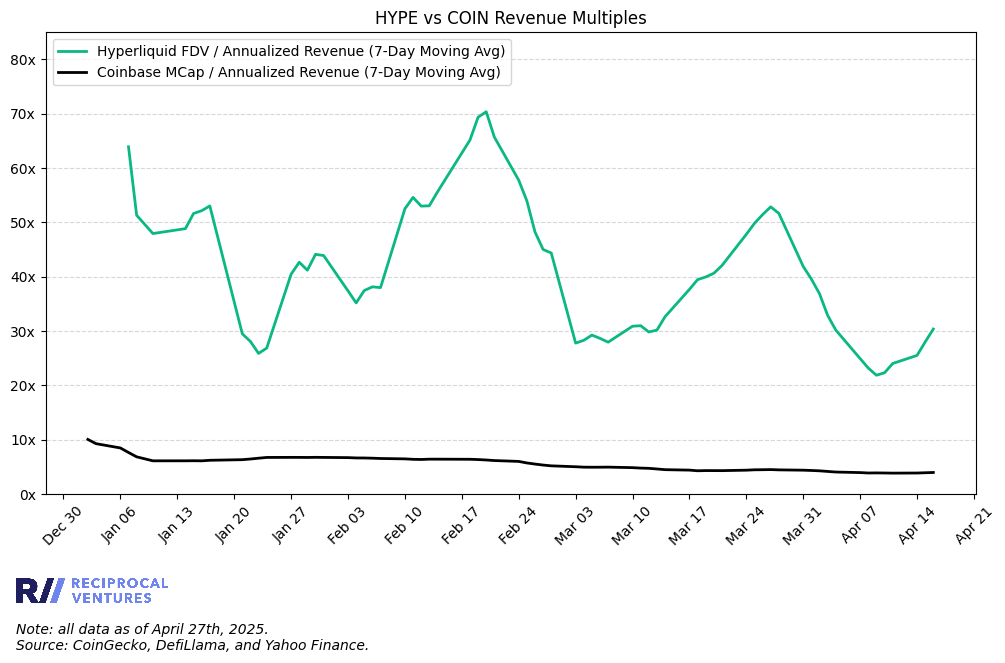

         date     fees  annualized-fees      price           fdv  \
61 2025-04-03  1715095        626009675  11.831829  1.183183e+10   
62 2025-04-04  1815068        662499820  11.716571  1.171657e+10   
63 2025-04-07  3117000       1137705000  10.266673  1.026667e+10   
64 2025-04-08  1746313        637404245  11.490222  1.149022e+10   
65 2025-04-09  2837027       1035514855  11.202466  1.120247e+10   
66 2025-04-10  1686123        615434895  13.580674  1.358067e+10   
67 2025-04-11  1327396        484499540  14.341905  1.434190e+10   
68 2025-04-14  1491560        544419400  15.362708  1.536271e+10   
69 2025-04-15  1221402        445811730  15.759650  1.575965e+10   
70 2025-04-16  1508963        550771495  15.109160  1.510916e+10   

    hype-fdv-rev-multiple  hype-fdv-rev-multiple-7d  coin_market_cap  \
61              18.900394                 32.867089     3.588607e+10   
62              17.685395                 30.163088     3.374039e+10   
63               9.024020          

In [9]:
# total supply for FDV
total_hype_tokens = 1000000000

# Load Hyperliquid fees data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-fees.json", "r") as f:
    fee_data = json.load(f)

fee_df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp_s", "fees"])
fee_df["date"] = pd.to_datetime(fee_df["timestamp_s"], unit="s")
fee_df = fee_df[["date", "fees"]]
fee_df['annualized-fees'] = fee_df['fees'] * 365

# Load Hyperliquid close price data
with open("raw-data/coingecko-raw-data/coingecko_hyperliquid_spot_strict_list_data.json", "r") as f:
    price_data = json.load(f)

price_df = pd.DataFrame(price_data["prices"], columns=["timestamp_ms", "price"])
price_df["date"] = pd.to_datetime(price_df["timestamp_ms"], unit="ms")  # use price_df, unit=ms
price_df = price_df[["date", "price"]]
price_df["fdv"] = price_df["price"] * total_hype_tokens

# Merge Hyperliquid datasets
df = pd.merge(fee_df, price_df, on="date", how="inner")
df["hype-fdv-rev-multiple"] = df["fdv"] / df["annualized-fees"]

# Calculate trailing 7-day average
df["hype-fdv-rev-multiple-7d"] = df["hype-fdv-rev-multiple"].rolling(window=7).mean()

# Load Coibnase close price data
with open("raw-data/yahoofinance-raw-data/COIN_mcap_to_annualized_rev.json", "r") as f:
    mcap_data = json.load(f)
mcap_df = pd.DataFrame.from_dict(mcap_data, orient="index")
mcap_df.index.name = "date"
mcap_df.reset_index(inplace=True)
mcap_df["date"] = pd.to_datetime(mcap_df["date"])

df = pd.merge(df, mcap_df, on="date", how="inner")

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    df["date"], df["hype-fdv-rev-multiple-7d"], color='#09b882',
    linewidth=2, label="Hyperliquid FDV / Annualized Revenue (7-Day Moving Avg)"
)
ax.plot(
    df["date"], df["coin_7d_avg"], color='black',
    linewidth=2, label="Coinbase MCap / Annualized Revenue (7-Day Moving Avg)"
)


# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("HYPE vs COIN Revenue Multiples")
ax.set_ylim(0, 85)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}x'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
ax.legend(loc="upper left")
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: CoinGecko, DefiLlama, and Yahoo Finance.", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/hyperliquid_vs_coinbase_multiples_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

print(df.tail(10))

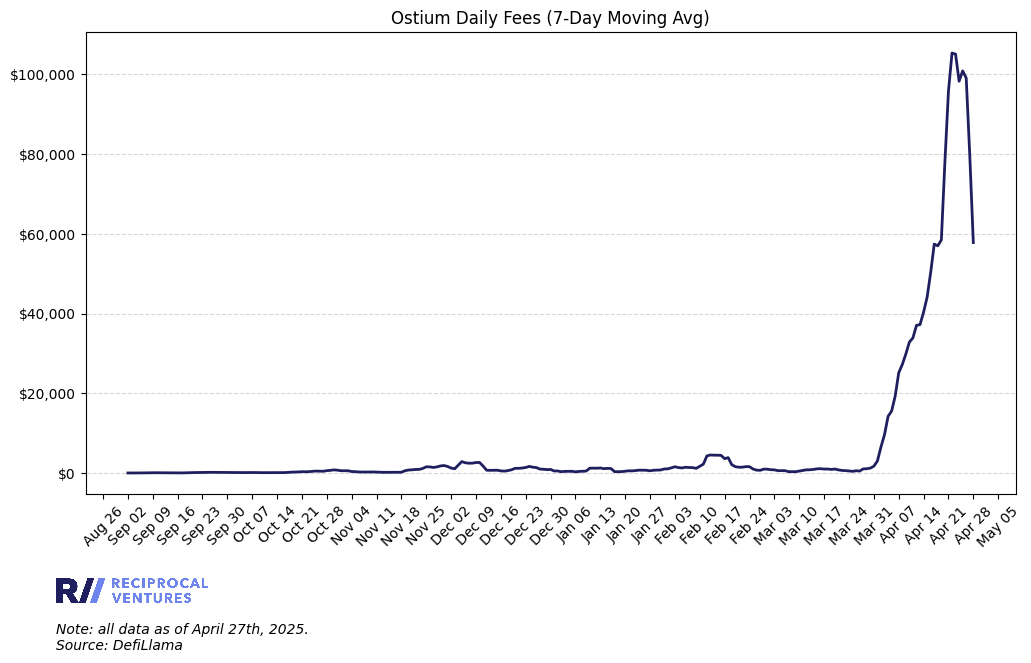

          date  ostium-fees  ostium-fees-7d
235 2025-04-19        42031    58473.428571
236 2025-04-20       165566    78023.857143
237 2025-04-21       190286    95741.571429
238 2025-04-22       118051   105350.285714
239 2025-04-23        86033   105063.285714
240 2025-04-24        45298    98270.571429
241 2025-04-25        58826   100870.142857
242 2025-04-26        29471    99075.857143
243 2025-04-27        29702    79666.714286
244 2025-04-28        37232    57801.857143


In [10]:
# Load Ostium fees data
with open("raw-data/defillama-raw-data/defillama_ostium-fees.json", "r") as f:
    fee_data = json.load(f)

df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "ostium-fees"])
df["date"] = pd.to_datetime(df["timestamp"], unit="s")
df = df[["date", "ostium-fees"]]

# Calculate trailing 7-day average
df["ostium-fees-7d"] = df["ostium-fees"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["ostium-fees-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting for weekly ticks
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

# Y-axis formatting
ax.set_title("Ostium Daily Fees (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/ostium_fees_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df.tail(10))

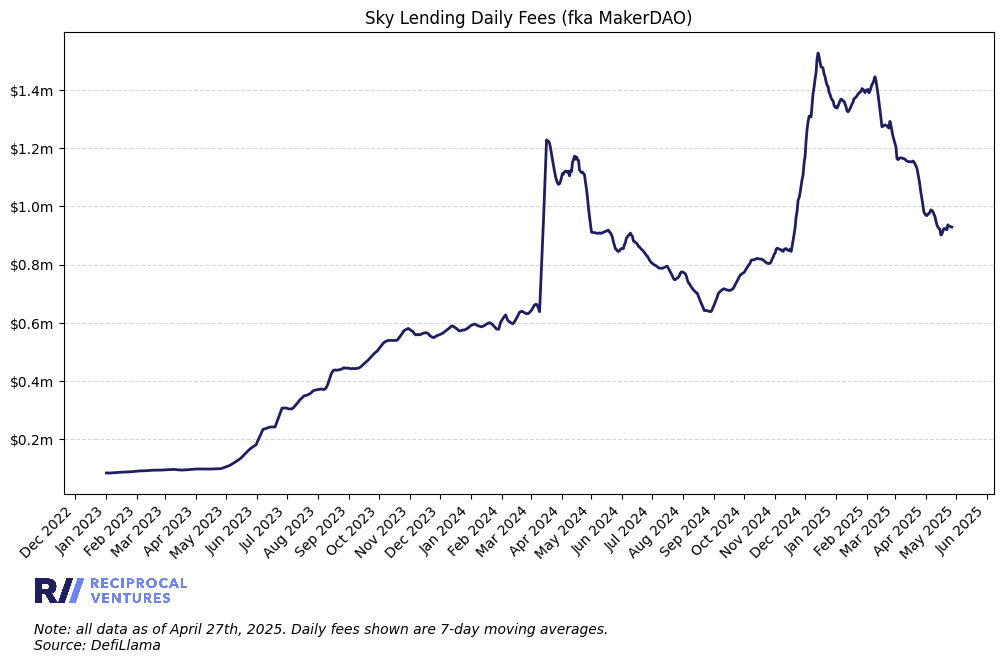

           date  makerdao-fees  makerdao-fees-7d
1977 2025-04-18         947710     914397.428571
1978 2025-04-19         948035     923904.857143
1979 2025-04-20         945795     923933.000000
1980 2025-04-21         923937     922127.285714
1981 2025-04-22         921570     919391.857143
1982 2025-04-23         920007     936633.285714
1983 2025-04-24         925294     933192.571429
1984 2025-04-25         936314     931564.571429
1985 2025-04-26         937226     930020.428571
1986 2025-04-27         938040     928912.571429


In [11]:
# Load Ostium fees data
with open("raw-data/defillama-raw-data/defillama_makerdao-fees.json", "r") as f:
    fee_data = json.load(f)

df = pd.DataFrame(fee_data["totalDataChart"], columns=["timestamp", "makerdao-fees"])
df["date"] = pd.to_datetime(df["timestamp"], unit="s")
df = df[["date", "makerdao-fees"]]

# Calculate trailing 7-day average
df["makerdao-fees-7d"] = df["makerdao-fees"].rolling(window=7).mean()

# Filter the data for a given time period
df = df[df['date'] >= '2023-01-01']

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["makerdao-fees-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# Y-axis formatting
ax.set_title("Sky Lending Daily Fees (fka MakerDAO)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000000:,.1f}m'))

# format x‑axis
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. Daily fees shown are 7-day moving averages.\nSource: DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/makerdao_fees_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df.tail(10))

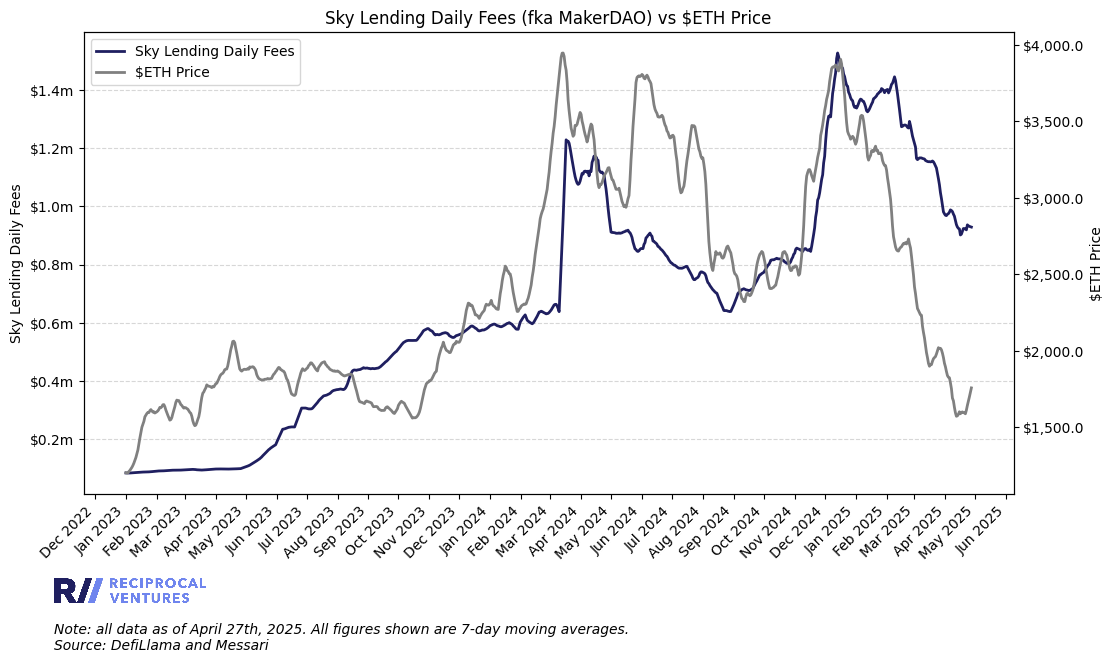

           date  makerdao-fees  makerdao-fees-7d        close  eth-close-7d
1090 2025-04-18         947710     914397.428571  1588.754277   1600.508143
1091 2025-04-19         948035     923904.857143  1612.709943   1596.019821
1092 2025-04-20         945795     923933.000000  1586.883934   1594.558109
1093 2025-04-21         923937     922127.285714  1579.737633   1588.312098
1094 2025-04-22         921570     919391.857143  1756.960500   1612.332287
1095 2025-04-23         920007     936633.285714  1795.998477   1643.512626
1096 2025-04-24         925294     933192.571429  1770.387703   1670.204638
1097 2025-04-25         936314     931564.571429  1786.165763   1698.406279
1098 2025-04-26         937226     930020.428571  1821.270171   1728.200597
1099 2025-04-27         938040     928912.571429  1791.689384   1757.458519


In [12]:
# Load MakerDAO fees data
with open("raw-data/defillama-raw-data/defillama_makerdao-fees.json", "r") as f:
    maker_data = json.load(f)

maker_df = pd.DataFrame(maker_data["totalDataChart"], columns=["timestamp", "makerdao-fees"])
maker_df["date"] = pd.to_datetime(maker_df["timestamp"], unit="s")
maker_df = maker_df[["date", "makerdao-fees"]]

# Calculate trailing 7-day average
maker_df["makerdao-fees-7d"] = maker_df["makerdao-fees"].rolling(window=7).mean()



# Load Ethereium price data
with open('raw-data/messari-raw-data/messari_ethereum_price.json', 'r') as f:
    eth_data = json.load(f)

points = eth_data['data']['points']
eth_df = pd.DataFrame(points, columns=[
    'timestamp',
    'open',
    'high',
    'low',
    'close',
    'volume'
])
eth_df["date"] = pd.to_datetime(eth_df["timestamp"], unit="s")
eth_df = eth_df[['date','close']]

# Calculate traling 7-dday average
eth_df['eth-close-7d'] = eth_df['close'].rolling(window=7).mean()

# Merge datasets
df = pd.merge(maker_df, eth_df, on="date", how="inner")

# Filter the data for a given time period
df = df[df['date'] >= '2023-01-01']

# Begin charting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot MakerDAO data
ax1.plot(df["date"], df["makerdao-fees-7d"], color="#1f1f60", linewidth=2, label="Sky Lending Daily Fees")
ax1.set_ylabel("Sky Lending Daily Fees")
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000000:,.1f}m'))

# format x‑axis
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# Plot $ETH data
ax2 = ax1.twinx()
ax2.plot(df["date"], df["eth-close-7d"], color="grey", linewidth=2, label="$ETH Price")
ax2.set_ylabel('$ETH Price')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x:,.1f}'))

# Clean up formatting
ax1.set_title("Sky Lending Daily Fees (fka MakerDAO) vs $ETH Price")
ax1.grid(axis='y', linestyle='--', alpha=0.5)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")
add_logo(ax1, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}. All figures shown are 7-day moving averages.\nSource: DefiLlama and Messari", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/makerdao_fees_vs_eth_price.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df.tail(10))

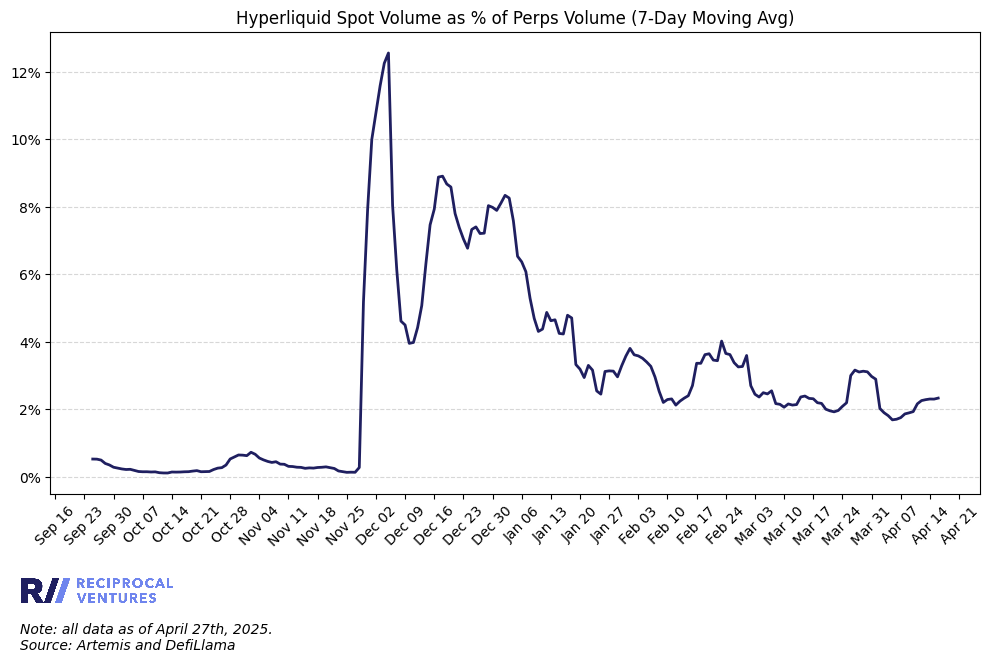

          date  spot-volume  perps-volume  spot-volume-percent-perps-volume  \
201 2025-04-08    163870707  7.827351e+09                          2.093565   
202 2025-04-09    256513559  1.270113e+10                          2.019611   
203 2025-04-10    165359677  7.394696e+09                          2.236193   
204 2025-04-11    187070232  5.731433e+09                          3.263935   
205 2025-04-12    121367900  5.070751e+09                          2.393490   
206 2025-04-13    134246965  6.333385e+09                          2.119671   
207 2025-04-14    126974634  6.316587e+09                          2.010178   
208 2025-04-15    120978471  5.825376e+09                          2.076750   
209 2025-04-16    155624952  6.982591e+09                          2.228756   
210 2025-04-17    171271416           NaN                               NaN   

     spot-volume-percent-perps-volume-7d  
201                             1.864049  
202                             1.895101  
2

In [13]:
# Load Hyperliquid spot volume data
with open("raw-data/defillama-raw-data/defillama_hyperliquid-spot-volumes.json", "r") as f:
    spot_volume_data = json.load(f)

spot_volume_df = pd.DataFrame(spot_volume_data["totalDataChart"], columns=["timestamp", "spot-volume"])
spot_volume_df["date"] = pd.to_datetime(spot_volume_df["timestamp"], unit="s")
spot_volume_df = spot_volume_df[["date", "spot-volume"]]

# Load Hyperliquid perps volume data
perps_volume_df = pd.read_csv('raw-data/artemis-raw-data/artemis_perps-trading-volume.csv')
perps_volume_df['Date'] = pd.to_datetime(perps_volume_df['Date'], format='%d-%b-%y')
perps_volume_df.rename(columns={'Date': 'date', 'Hyperliquid': 'perps-volume'}, inplace=True)

# Merge datasets
df = pd.merge(perps_volume_df, spot_volume_df, on="date", how="inner")
df["spot-volume-percent-perps-volume"] = df["spot-volume"] / df["perps-volume"] * 100 # convert to %

# Calculate trailing 7-day average
df["spot-volume-percent-perps-volume-7d"] = df["spot-volume-percent-perps-volume"].rolling(window=7).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df["date"], df["spot-volume-percent-perps-volume-7d"], color="#1f1f60", linewidth=2, label="7D Avg")

# X-axis formatting: show ticks weekly, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Hyperliquid Spot Volume as % of Perps Volume (7-Day Moving Avg)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}%'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/spot-volume-percent-perps-volume_7d_avg.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df[["date", "spot-volume", "perps-volume", "spot-volume-percent-perps-volume", "spot-volume-percent-perps-volume-7d"]].tail(10))


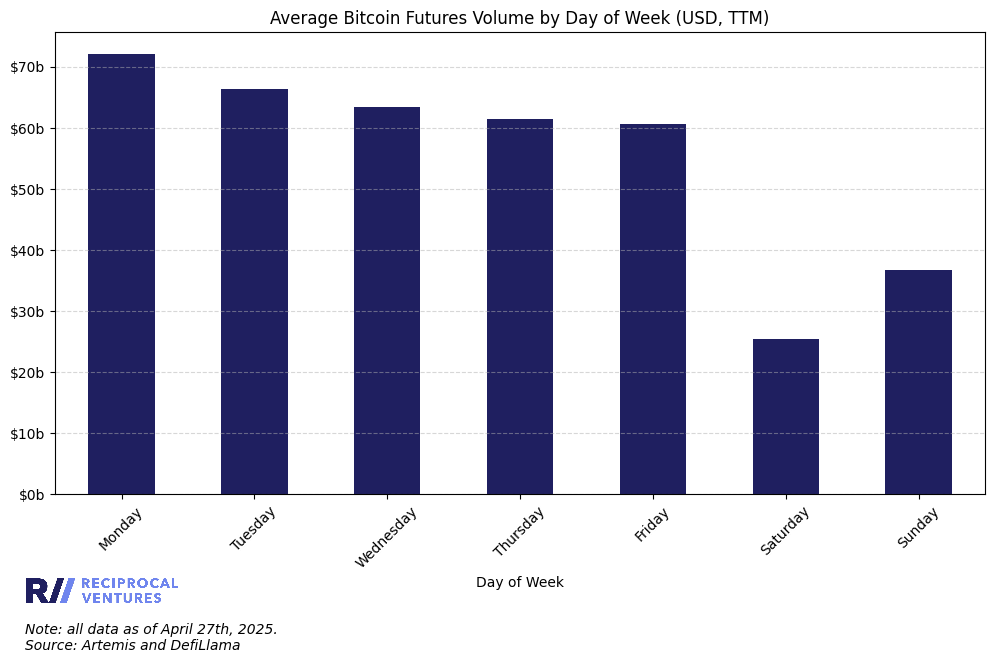

      timestamp  trade_count    volume_usd    volume_btc  volume_other  \
356  1744675200      9657446  5.302851e+10  2.624584e+10  2.678267e+10   
357  1744761600     10240392  5.703359e+10  2.829677e+10  2.873682e+10   
358  1744848000      7154562  4.058176e+10  2.053338e+10  2.004838e+10   
359  1744934400      2844152  1.556197e+10  7.776613e+09  7.785354e+09   
360  1745020800      3584468  2.208868e+10  1.114294e+10  1.094574e+10   
361  1745107200      4089698  2.270491e+10  1.132268e+10  1.138224e+10   
362  1745193600     11988025  7.408143e+10  3.779163e+10  3.628981e+10   
363  1745280000     14517137  9.321374e+10  4.890543e+10  4.430831e+10   
364  1745366400     11826069  7.172604e+10  3.568399e+10  3.604206e+10   
365  1745452800      8450413  5.054950e+10  2.558102e+10  2.496848e+10   

          date day_of_week  
356 2025-04-15     Tuesday  
357 2025-04-16   Wednesday  
358 2025-04-17    Thursday  
359 2025-04-18      Friday  
360 2025-04-19    Saturday  
361 2025-04

In [14]:
# Load the JSON data
with open('raw-data/messari-raw-data/messari_bitcoin_futures-volume.json', 'r') as f:
    raw = json.load(f)

# Build a DataFrame; adjust column names if yours differ
points = raw['data']['points']
df = pd.DataFrame(points, columns=[
    'timestamp',
    'trade_count',
    'volume_usd',
    'volume_btc',
    'volume_other'
])

# Convert the UNIX timestamp to datetime and extract weekday names
df['date'] = pd.to_datetime(df['timestamp'], unit='s')
df['day_of_week'] = df['date'].dt.day_name()

# Compute the average USD volume for each day of the week
avg_volume = df.groupby('day_of_week')['volume_usd'].mean()

# Reorder the index so days run from Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_volume = avg_volume.reindex(weekday_order)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
avg_volume.plot(kind='bar', ax=ax, color="#1f1f60")

# X-axis formatting
plt.xlabel('Day of Week')
plt.xticks(rotation=45)

# Y-axis formatting
ax.set_title("Average Bitcoin Futures Volume by Day of Week (USD, TTM)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'${x/1000000000:.0f}b'))

plt.grid(axis='y', linestyle='--', alpha=0.5)
add_logo(ax, position=(0.05, -0.21))
plt.figtext(0.1, -0.15, f"Note: all data as of {date}.\nSource: Artemis and DefiLlama", ha='left', fontsize=10, style='italic')

# Save plot
if not os.path.exists("plots"):
    os.makedirs("plots")
plt.savefig("plots/bitcoin-futures-by-day-of-week.png", dpi=300, bbox_inches='tight')
plt.show()

# Print sample of the dataset with 7D average
print(df.tail(10))
